In [6]:
import numpy as np
from scipy.interpolate import interp2d, griddata
import csv
import os
import pandas as pd
import xarray as xr
# import proplot as plot
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from scipy.stats import pearsonr
import sys
np.set_printoptions(threshold=sys.maxsize)
# from mpl_toolkits.basemap import Basemap
import datetime 
from scipy import stats
from netCDF4 import Dataset
from sklearn.linear_model import LinearRegression
from mpl_toolkits.basemap import Basemap
import watermark
%matplotlib inline
%load_ext watermark

ModuleNotFoundError: No module named 'watermark'

In [7]:
%watermark -a 'Inigo Peng' -d -t -v -p numpy, pands, scipy, netCDF4, pandas

UsageError: Line magic function `%watermark` not found.


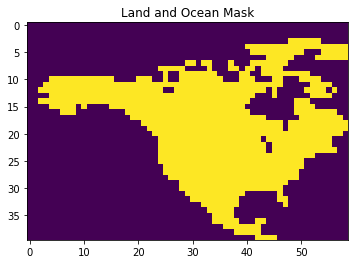

In [419]:
#Land mask for temperature calculation

lmfile = r'C:\Users\inigo\Documents\MATLAB\NCEP_Data\NCEP_R2\land.sfc.gauss.nc'
lmset = Dataset(lmfile)
lsmask = lmset['land'][0, 0:40, 102:161]
plt.imshow(lsmask)
plt.title ('Land and Ocean Mask')
lsm = lsmask 
lsm = lsm.astype('float32')
lsm[lsm == 0] = -1
lsm[lsm == 1] = 0
lsm = lsm + 1
lsm [lsm<1.0] = np.nan

In [420]:
def open_data(data):
    '''
    open ncep dataset using xarray
    
    Parameters
    ---
    .nc files: string
        the ncep dataset
    
    Returns
    ---
    xarray dataset
        ncep data as xarray dataset
    '''
    
    new_data = xr.open_dataset(data)
    return new_data

In [421]:
def select_data(data_set, climate_var,months):
    '''
    parse the geopotential height NCEP data that is found at https://psl.noaa.gov/data/gridded/data.ncep.reanalysis2.pressure.html
    temperature data is found at https://psl.noaa.gov/data/gridded/data.ncep.reanalysis2.gaussian.html
    
    Parameters
    ---
    xarray dataset: string
    climate_var: string
        parse either hgt or temperature
    time_var: string
        parse time.month
    months: list
        list of months eg.[1,2,3]
    
    Returns
    ---
    xarray dataset
    '''
    result = data_set[climate_var].sel(time=np.in1d(data_set['time.month'],[months])).squeeze()
    if climate_var == 'hgt':
        if months == [12, 1, 2]:
            hgt = result.sel(time = slice('1979-12-01','2020-3-01'),level = slice(500,500), lon = slice (100, 360), lat = slice(-30)).squeeze()
            return hgt
        elif months == [3,4,5]:
            hgt = result.sel(time = slice('1980-3-01','2020-6-01'),level = slice(500,500), lon = slice (100, 360), lat = slice(-30)).squeeze()
            return hgt
        elif months == [6,7,8]:
            hgt = result.sel(time = slice('1980-6-01','2020-9-01'),level = slice(500,500), lon = slice (100, 360), lat = slice(-30)).squeeze()
            return hgt
        elif months == [9,10,11]:
            hgt = result.sel(time = slice('1980-9-01','2020-12-01'),level = slice(500,500), lon = slice (100, 360), lat = slice(-30)).squeeze()
            return hgt
        elif months == [10, 11,12]:
            hgt = result.sel(time = slice('1980-10-01','2021-1-01'),level = slice(500,500), lon = slice (100, 360), lat = slice(-30)).squeeze()
            return hgt
        elif months == [11,12]:
            hgt = result.sel(time = slice('1980-11-01','2021-1-01'),lon = slice (190, 300), lat = slice(13)).squeeze()
            return hgt

    elif climate_var == 'air':
        if months == [12, 1, 2]:
            temp = result.sel(time = slice('1979-12-01','2020-3-01'),lon = slice (190, 300), lat = slice(13)).squeeze()
            return temp
        elif months == [3,4,5]:
            temp = result.sel(time = slice('1980-3-01','2020-6-01'),lon = slice (190, 300), lat = slice(13)).squeeze()
            return temp
        elif months == [6,7,8]:
            temp = result.sel(time = slice('1980-6-01','2020-9-01'),lon = slice (190, 300), lat = slice(13)).squeeze()
            return temp
        elif months == [9,10,11]:
            temp = result.sel(time = slice('1980-9-01','2020-12-01'),lon = slice (190, 300), lat = slice(13)).squeeze()
            return temp
        elif months == [10,11,12]:
            temp = result.sel(time = slice('1980-10-01','2021-1-01'),lon = slice (190, 300), lat = slice(13)).squeeze()
            return temp
        elif months == [11,12]:
            temp = result.sel(time = slice('1980-11-01','2021-1-01'),lon = slice (190, 300), lat = slice(13)).squeeze()
            return temp


In [422]:
def detrend_hgt(hgt):
    '''
    remove linear seasonal trend from geopotential height data
    also converts data to numpy array 
    
    Parameters
    ---
    hgt: string
        geopotential height xarray dataset
    
    Returns
    ---
    numpy array
    '''
    hgt_clm = hgt.groupby('time.month').mean(dim = 'time')
    hgt_anom = hgt.groupby('time.month') - hgt_clm
    hgt_anom = hgt_anom.values
    
    return hgt_anom

In [423]:
def detrend_temp(temp):
    '''
    remove linear seasonal trend from masked norther america temperature data
    convert data to numpy array 
    
    Parameters
    ---
    temp: string
        temperature xarray dataset
    
    Returns
    ---
    numpy array
    '''
    temp_time, temp_row, temp_col = temp.shape
    lsm = np.stack([lsmask]*temp_time,axis=-1).transpose((2,0,1)) #stack the mask for all of the years
    temp_2d = temp*lsm
    temp_masked = np.ma.masked_array(temp_2d, mask = np.isnan(temp_2d))
    month1 = np.mean(temp_masked[0::3], axis = 0)
    month2 = np.mean(temp_masked[1::3], axis = 0)
    month3 = np.mean(temp_masked[2::3], axis = 0)
    temp_masked[0::3] = np.subtract(temp_masked[0::3], month1)
    temp_masked[1::3] = np.subtract(temp_masked[1::3], month2)
    temp_masked[2::3] = np.subtract(temp_masked[2::3], month3)
    temp_anom_masked = np.reshape(temp_masked, (temp_time, temp_row, temp_col), order = 'F') 
    
    return temp_anom_masked


In [424]:
def svd(temp, hgt):
    '''
    calculate maximum covariance of hgt and temperature using singular value decomposition
    MCA can isolate important coupled modes of variability between two fields
    
    Parameters
    ---
    temp: numpy array
    hgt: numpy array
    
    Returns
    ---
    tuples
        contains first and second temperature and hgt MCA pattern
        and its corresponding expansion coefficients
    '''
    #Preprocess - convert 3D temp and hgt data to 2D arrays
    temp_time, temp_row, temp_col = temp.shape
    temp_2d = np.reshape(temp, (temp_time, temp_row*temp_col), order = 'F')
    
    ntime_anom, hgt_row, hgt_col = hgt.shape
    hgt_2d = np.reshape(hgt, (ntime_anom, hgt_row*hgt_col), order = 'F')
    
    #Carry out Maximum Covariance Analysis
    #Create covariance matrix of temp and hgt by finding the dot product
    Cxy = np.dot(temp_2d.T, hgt_2d)/(temp_time -1.0)
    
    #Apply Singular Value Decomposition to decompose the covariance matrix
    #s is the diagnoal matrix of eigenvalues
    #U is the left singular vectors of Cxy 
    #V is the right singular vectors of Cxy
    U, s, V = np.linalg.svd(Cxy, full_matrices=False)
    scf = s**2./np.sum(s**2.0) #calculate cumulative fraction of squared covariance fraction (SCF, %) explained
    V = V.T
    imode = 0 
    print(scf[imode])
    print(scf[1])
    
    #Extract the leading (mode0) Temperature MCA Pattern and project onto the original data
    U1 = np.reshape(U[:,0, None], (temp_row, temp_col), order='F')
    #Expansion coefficient 1 (EC1) of temperature pattern 
    a1 = np.dot(temp_2d, U[:,0, np.newaxis])
    #Normalize the leading mode by standardizing with EC1 so patterns correspond to 1-std variation in EC1
    U1_norm = U1*np.std(a1)
    a1_norm = a1/np.std(a1)

    #Exract and project the second leading (mode1) Temperature MCA and EC2
    U2 = np.reshape(U[:,1, None], (temp_row, temp_col), order='F')
    a2 = np.dot(temp_2d, U[:,1, np.newaxis])
    U2_norm = U2*np.std(a2)
    a2_norm = a2/np.std(a2)
    
    #Extract the leading (mode0) HGT MCA pattern and project onto the original data
    V1 = np.reshape(V[:,0, None], (hgt_row, hgt_col), order='F')
    #Expansion coefficient 1 (EC1) of HGT pattern 
    b1 = np.dot(hgt_2d, V[:,0, np.newaxis])
    #Normalize by standardizing with HGT EC1
    V1_norm = V1*np.std(b1)
    b1_norm = b1/np.std(b1)
    
    #Extract and project the second leading (mode1) HGT MCA pattern and EC2
    V2 = np.reshape(V[:,1, None], (hgt_row, hgt_col), order='F')
    b2 = np.dot(hgt_2d, V[:,1, np.newaxis])
    V2_norm = V2*np.std(b2)
    b2_norm = b2/np.std(b2)
    return U1_norm, a1_norm, U2_norm, a2_norm, V1_norm, b1_norm, V2_norm, b2_norm, scf

In [425]:
def calculate_EC(a1_norm, b1_norm, a2_norm, b2_norm):
    '''
    create expansion coefficient index by finding the mean of temperature and hgt related coefficient
    
    Parameters
    ---
    a1_norm: numpy array
    b1_norm: numpy array
    a2_norm: numpy array
    b2_norm: numpy array
    
    Returns
    ---
    tuples
        contains seasonal average EC1 and EC2 (which are used as EC indices) and monthly EC1 and EC2
    '''    
    EC1 = (a1_norm + b1_norm)/2
    EC2 = (a2_norm + b2_norm)/2
    EC1 = EC1.astype('float64')
    EC2 = EC2.astype('float64')
    EC1_annual = np.mean(EC1.reshape(-1, 3), axis=1) #3 month EC average
    EC2_annual = np.mean(EC2.reshape(-1, 3), axis=1)
    EC1_annual = np.squeeze(EC1_annual)
    EC2_annual = np.squeeze(EC2_annual)
    return EC1_annual, EC2_annual, EC1, EC2

In [426]:
def read_file(file, months):
    '''
    read CPC dataset 
    PNA index: https://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/norm.pna.monthly.b5001.current.ascii
    AO index: https://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/monthly.ao.index.b50.current.ascii
    NAO index: https://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/norm.nao.monthly.b5001.current.ascii
    
    Parameters
    ---
    file: .txt file

    
    Returns
    ---
    panda data frame
        pna data from dec 1979 - dec 2020
    '''    
    
    data = pd.read_csv(file,delim_whitespace = True, header = None,names = ['Year', 'Month','Value'])
    if months == 'djf':
        data.drop(data[(data.Month > 2) & (data.Month < 12) ].index, inplace= True)
        data.drop(data[(data.Year < 1979)].index, inplace= True)
        data.drop(data[(data.Year < 1980) & (data.Month < 12)].index, inplace = True)
        data.drop(data[(data.Year > 2020)].index, inplace = True)
        data.drop(data[(data.Year > 2019) & (data.Month > 2)].index, inplace = True)
        data_value = data.Value
        print(data)
        return data_value
    elif months == 'mam':
        data.drop(data[(data.Month > 5)].index, inplace= True)
        data.drop(data[(data.Month < 3)].index, inplace= True)
        data.drop(data[(data.Year < 1980)].index, inplace = True)
        data.drop(data[(data.Year > 2020)].index, inplace = True)
        print(data)
        data_value = data.Value
        return data_value
    elif months == 'jja':
        data.drop(data[(data.Month > 8)].index, inplace= True)
        data.drop(data[(data.Month < 6)].index, inplace= True)
        data.drop(data[(data.Year < 1980)].index, inplace = True)
        data.drop(data[(data.Year > 2020)].index, inplace = True)
        print(data)
        data_value = data.Value
        return data_value
    elif months == 'son':
        data.drop(data[(data.Month > 11)].index, inplace= True)
        data.drop(data[(data.Month < 9)].index, inplace= True)
        data.drop(data[(data.Year < 1980)].index, inplace = True)
        data.drop(data[(data.Year > 2020)].index, inplace = True)
        print(data)
        data_value = data.Value
        return data_value
    elif months == 'ond':
        data.drop(data[(data.Month > 12)].index, inplace= True)
        data.drop(data[(data.Month < 10)].index, inplace= True)
        data.drop(data[(data.Year < 1980)].index, inplace = True)
        data.drop(data[(data.Year > 2021)].index, inplace = True)
        print(data)
        data_value = data.Value
        return data_value


In [427]:
def new_hgt_data(months):
    '''
    use different latitude to calculate PNA contribution to geopotential height
    
    Parameters
    ---
    months: list

    
    Returns
    ---
    xarray dataset 
    '''    
    result = dset_hgt['hgt'].sel(time=np.in1d(dset_hgt['time.month'],[months])).squeeze()
    if months == [12, 1, 2]:
        hgt = result.sel(time = slice('1979-12-01','2020-3-01'),level = slice(500,500), lon = slice (35, 360), lat = slice(-30)).squeeze()
        return hgt
    elif months == [3,4,5]:
        hgt = result.sel(time = slice('1980-3-01','2020-6-01'),level = slice(500,500), lon = slice (35, 360), lat = slice(-30)).squeeze()
        return hgt
    elif months == [6,7,8]:
        hgt = result.sel(time = slice('1980-6-01','2020-9-01'),level = slice(500,500), lon = slice (35, 360), lat = slice(-30)).squeeze()
        return hgt
    elif months == [9,10,11]:
        hgt = result.sel(time = slice('1980-9-01','2020-12-01'),level = slice(500,500), lon = slice (35, 360), lat = slice(-30)).squeeze()
        return hgt
    elif months == [10,11,12]:
        hgt = result.sel(time = slice('1980-10-01','2021-1-01'),level = slice(500,500), lon = slice (35, 360), lat = slice(-30)).squeeze()
        return hgt   
    elif months == [11,12]:
        hgt = result.sel(time = slice('1980-11-01','2021-1-01'),level = slice(500,500), lon = slice (35, 360), lat = slice(-30)).squeeze()
        return hgt     

In [428]:
def pna_contribution(hgt, pna):
    '''
    find PNA contribution in hgt throughout the years
    
    Parameters
    ---
    hgt: xarray dataset
    pna: panda dataframe

    
    Returns
    ---
    PNA_contribution: numpy array
    '''   
    
    PNA_contribution = np.array([])
    ntime_contr = 1
    
    ntime_anom, hgt_row, hgt_col = hgt.shape
    hgt_2d = np.reshape(hgt, (ntime_anom, hgt_row*hgt_col), order = 'F')
    
    ngrd = hgt_row * hgt_col
    pna_coef = np.zeros((1, ngrd))
    pna = pna.values.reshape(-1,1) # data needs to be two-dimensional - one column and many rows
    
    #find PNA contribution using linear regression
    model = LinearRegression()
    
    #pna value is the regressor
    #how does hgt change throughout spaces with different pna values?
    for igrd in np.arange(ngrd):
        model_lin = model.fit(pna, hgt_2d[:,igrd])
        coef = model_lin.coef_ #the mean change in hgt for additional change in pna
        pna_coef[0,igrd] = coef 
    pna_coef = pna_coef.reshape((ntime_contr, hgt_row, hgt_col), order = 'F').squeeze()

    #find pna contribution throughout time
    for item in pna:
        if PNA_contribution.size == 0:
            PNA_contribution = item*pna_coef
            PNA_contribution = PNA_contribution.reshape(ntime_contr, hgt_row, hgt_col, order = 'F')
        else:
            pna_contribution_2d = item *pna_coef
            pna_contribution_2d =pna_contribution_2d.reshape(ntime_contr, hgt_row, hgt_col, order = 'F')
            PNA_contribution = np.append(PNA_contribution, pna_contribution_2d, axis = 0)
   
    return PNA_contribution

In [429]:
def hgt_regressed_ec(hgt, ec):
    '''
    find geopotential height anomalies regressed upon EC to show the relationship between EC and circulation anomalies 
    
    Parameters
    ---
    hgt: xarray dataset
    ec: list

    
    Returns
    ---
    ec_coef: numpy array
    '''   
    ntime_contr = 1
    
    ntime_anom, hgt_row, hgt_col = hgt.shape
    hgt_2d = np.reshape(hgt, (ntime_anom, hgt_row*hgt_col), order = 'F')
    
    ngrd = hgt_row * hgt_col
    ec_coef = np.zeros((1, ngrd))
    
    model = LinearRegression()
    for igrd in np.arange(ngrd):
        model_lin = model.fit(ec.reshape((-1,1)), hgt_2d[:,igrd])
        reg_coef = model_lin.coef_
        ec_coef[0,igrd] = reg_coef
    ec_coef = ec_coef.reshape((ntime_contr, hgt_row,hgt_col), order = 'F').squeeze()
    return ec_coef

In [430]:
def calculate_index(hgt_anom, PNA_Contribution):
    '''
    linearly remove pna contribution from global geopotential anomalies
    Normalize geopotential anomaly at each grid point by its standard deviation
    Average the anomalies over three regions:
    
        A (40 - 55 degrees N, 100-127.5 degrees E)
        B (50 - 80 degrees N, 160 degrees E - 150 degrees W)
        C (40 - 60 degrees N, 100 - 70 degrees W)
    
    Then calculate the two indices:
    
        ABNA = meanA - meanB + meanC
        new_index = meanC - meanB
    
    Parameters
    ---
    hgt_anom:numpy array
    PNA_contribution: numpy array

    
    Returns
    ---
    tuples
        first element is the ABNA index second element is the new index
    '''   
    
    noPNA = np.subtract(hgt_anom, PNA_Contribution)
    sd = np.std(noPNA, axis = 0)
    noPNA_sd = noPNA/sd
    
    noPNA_A = noPNA_sd[:, 14:21, 40:52]
    PNA_A_time, PNA_A_lon, PNA_A_lat = noPNA_A.shape
    noPNA_A = noPNA_A.reshape(PNA_A_time, PNA_A_lon * PNA_A_lat)
    
    
    noPNA_B = noPNA_sd[:, 4:17, 64:85]
    PNA_B_time, PNA_B_lon, PNA_B_lat = noPNA_B.shape
    noPNA_B = noPNA_B.reshape(PNA_B_time, PNA_B_lon * PNA_B_lat)
    
    noPNA_C = noPNA_sd[:, 12:21, 104:117]
    PNA_C_time, PNA_C_lon, PNA_C_lat = noPNA_C.shape
    noPNA_C = noPNA_C.reshape(PNA_C_time, PNA_C_lon * PNA_C_lat)
    
    #average the regional normalized hgt
    mean_a = np.mean(noPNA_A, axis = 1)
    mean_b = np.mean(noPNA_B, axis = 1)
    mean_c = np.mean(noPNA_C, axis = 1)
    
    ABNA = mean_a - mean_b + mean_c
    new_index = mean_c - mean_b
    third_index = mean_b
    ABNA = pd.DataFrame(ABNA, columns = ['Value'])
    new_index = pd.DataFrame(new_index, columns = ['Value'])
    third_index = pd.DataFrame(third_index, columns = ['Value'])
    
    return ABNA, new_index, noPNA, third_index

In [431]:
def find_correlation(dataset1, dataset2):
    '''
    perform pearson correlation
    
    Parameters
    ---
    dataset1: numpy array
    dataset2: numpy array

    
    Returns
    ---
    tuples
        first element is the correlation second element is the pvalue
    ''' 
    crr, pvalue = pearsonr(dataset1, dataset2)
    print('Correlation: ' + str(crr))
    print('P-value: ' + str(pvalue))
    
    return crr, pvalue
    

In [432]:
def map_temp(svd_result, title):
    '''
    create geovisualization for temperature from maximum covariance analysis
    
    Parameters
    ---
    svd_results: 
    title: string
    
    Returns
    ---
    image 
    '''
    parallels = np.arange(25,90,20.)
    meridians = np.arange(-180,180,20)
    infile = 'C:/Users/inigo/Documents/MATLAB/NCEP_Data/NCEP_R2/air.2m.mon.mean.nc'
    ncin = Dataset(infile, 'r')
    lat  = ncin.variables['lat'][0:40]
    lon  = ncin.variables['lon'][102:161]
    m = Basemap(projection='cyl', llcrnrlon=min(lon), llcrnrlat=min(lat),
        urcrnrlon=max(lon), urcrnrlat=max(lat))
    x, y = m(*np.meshgrid(lon, lat))
    fig = plt.figure(figsize=(15,12))
    levels = np.arange(-1.6, 2, 0.4)
    ax = fig.add_subplot(211)
    cs = m.contourf(x, y, svd_result, levels,cmap=plt.cm.RdBu_r, extend = 'both')
    m.drawcoastlines()
    m.drawparallels(parallels, labels=[1,0,0,0])
    m.drawmeridians(meridians, labels=[1,0,0,1])
    plt.colorbar()
    plt.title(title)
    plt.savefig(title +'.png')

    

In [433]:
def map_hgt(result, title):
    '''
    create geovisualization for geopotential height from maximum covariance analysis
    
    Parameters
    ---
    svd_results: 
    title: string
    
    Returns
    ---
    image 
    '''
    infile = 'C:/Users/inigo/Documents/MATLAB/NCEP_Data/NCEP_R2/hgt.mon.mean.nc'
    ncin = Dataset(infile, 'r')
    hgt_lat  = ncin.variables['lat'][0:-24]
    hgt_lon  = ncin.variables['lon'][40:]
    parallels = np.arange(-30,90,20.)
    meridians = np.arange(-180,180,20)

    m = Basemap(projection='cyl', llcrnrlon=min(hgt_lon), llcrnrlat=min(hgt_lat),
        urcrnrlon=max(hgt_lon), urcrnrlat=max(hgt_lat))

    x, y = m(*np.meshgrid(hgt_lon, hgt_lat))

    fig = plt.figure(figsize=(15,12))
    ax = fig.add_subplot(211)
    levels = np.arange(-80, 100, 20)

    cs = m.contourf(x, y, result, levels, cmap=plt.cm.RdBu_r)
    m.drawcoastlines()
    m.drawparallels(parallels, labels=[1,0,0,0])
    m.drawmeridians(meridians, labels=[1,0,0,1])
    lon2d, lat2d = np.meshgrid(hgt_lon, hgt_lat)
    plt.colorbar()
    plt.title(title)
    plt.savefig(title +'.png')



In [434]:
def map_hgt_ec(hgt_anom, ec, title):
    '''
    create geovisualization for geopotential height regressed upon ec
    
    Parameters
    ---
    results: 
    title: string
    
    Returns
    ---
    image 
    '''
    ntime_anom, hgt_row, hgt_col = hgt_anom.shape
    hgt_anom_2d = np.reshape(hgt_anom, (ntime_anom, hgt_row*hgt_col), order = 'F')
    
    ngrd = hgt_row * hgt_col
    corr = np.zeros((1, ngrd))
    pval = np.zeros((1, ngrd))
    
    for igrd in np.arange(ngrd):
        crr, pvalue = pearsonr(ec[:,0], hgt_anom_2d[:,igrd])
        corr[0,igrd] = crr
        pval[0,igrd] = pvalue
    
    corr = corr.reshape((hgt_row, hgt_col), order='F')
    pval = pval.reshape((hgt_row, hgt_col), order='F')
    
    infile = 'C:/Users/inigo/Documents/MATLAB/NCEP_Data/NCEP_R2/hgt.mon.mean.nc'
    ncin = Dataset(infile, 'r')

    hgt2_lat  = ncin.variables['lat'][:-24]
    hgt2_lon  = ncin.variables['lon'][14:]
    ncin.close()
    parallels = np.arange(-30,90,20.)
    meridians = np.arange(-180,180,20)
    m = Basemap(projection='cyl', llcrnrlon=min(hgt2_lon), llcrnrlat=min(hgt2_lat),
        urcrnrlon=max(hgt2_lon), urcrnrlat=max(hgt2_lat))

    x, y = m(*np.meshgrid(hgt2_lon, hgt2_lat))

    fig = plt.figure(figsize=(15,12))
    ax = fig.add_subplot(211)
    corr_sig = np.ma.masked_array(corr, mask=(pval>=0.05))
    cs = m.contourf(x, y, corr_sig, cmap=plt.cm.RdBu_r)
    m.drawcoastlines()
    m.drawparallels(parallels, labels=[1,0,0,0])
    m.drawmeridians(meridians, labels=[1,0,0,1])
    plt.colorbar()
    plt.title(title)
    plt.savefig(title +'.png')




In [435]:
def map_ec2_no_pna(ec2, nopna, title):

#     ntime_anom, hgt_row, hgt_col = hgt.shape
    ntime_pna, pna_row, pna_col = nopna.shape
#     hgt_2d = np.reshape(hgt, (ntime_anom, hgt_row*hgt_col), order = 'F')
#     ntime_contr = 41
    nopna = nopna.reshape(ntime_pna, pna_row* pna_col)
    
    ngrd = pna_row * pna_col
    corr = np.zeros((1, ngrd))
    pval = np.zeros((1, ngrd))
    
    print(ec.shape)
    print(nopna[:,1].shape)
    
    for igrd in np.arange(ngrd):
        crr, pvalue = pearsonr(ec[:,0], nopna[:, igrd])
        corr[0,igrd] = crr
        pval[0,igrd] = pvalue
    
    corr = corr.reshape((pna_row, pna_col), order = 'F')
#     print(corr.shape)
    pval = pval.reshape((pna_row, pna_col), order='F')
    
    infile = 'C:/Users/inigo/Documents/MATLAB/NCEP_Data/NCEP_R2/hgt.mon.mean.nc'
    ncin = Dataset(infile, 'r')
    hgt_lat  = ncin.variables['lat'][:-24]
    hgt_lon  = ncin.variables['lon'][14:]
    parallels = np.arange(-30,90,20.)
    meridians = np.arange(-180,180,20)

    m = Basemap(projection='cyl', llcrnrlon=min(hgt_lon), llcrnrlat=min(hgt_lat),
        urcrnrlon=max(hgt_lon), urcrnrlat=max(hgt_lat))

    x, y = m(*np.meshgrid(hgt_lon, hgt_lat))

    fig = plt.figure(figsize=(15,12))
    ax = fig.add_subplot(211)
    clevs = np.linspace(-1.0, 1.0, 21)
#     levels = np.arange(-75, 60, 5)
    
    corr_sig = np.ma.masked_array(corr, mask=(pval>=0.05))
    cs = m.contourf(x, y, corr_sig.squeeze(), clevs, cmap=plt.cm.RdBu_r)
    m.drawcoastlines()
    m.drawparallels(parallels, labels=[1,0,0,0])
    m.drawmeridians(meridians, labels=[1,0,0,1])
#     lon2d, lat2d = np.meshgrid(hgt_lon, hgt_lat)
    plt.colorbar()
    plt.title(title)
    plt.savefig(title +'.png')

In [436]:
def divide_chunks(l, n): 
      
    # looping till length l 
    for i in range(0, len(l), n):  
        yield l[i:i + n] 

In [437]:
def create_data_frame(values, months):
    ABNA_values = values.Value.values
    index = list(divide_chunks(ABNA_values, 3)) 
    df = pd.DataFrame(columns = months)
    for x in index:
        to_append = x
        df_length = len(df)
        df.loc[df_length] = to_append
    return df

Select Geopotential Height Data

In [438]:
dset_hgt = open_data('C:/Users/inigo/Documents/MATLAB/NCEP_Data/NCEP_R2/hgt.mon.mean.nc')
dset_temp= open_data('C:/Users/inigo/Documents/MATLAB/NCEP_Data/NCEP_R2/air.2m.mon.mean.nc')

In [439]:
hgt_djf = select_data(dset_hgt, climate_var = 'hgt', months = [12,1,2])
temp_djf = select_data(dset_temp, climate_var = 'air',months = [12,1,2])

In [440]:
hgt_mam = select_data(dset_hgt, climate_var = 'hgt', months = [3,4,5])
temp_mam = select_data(dset_temp, climate_var = 'air', months = [3,4,5])

In [441]:
hgt_jja = select_data(dset_hgt, climate_var = 'hgt', months = [6,7,8])
temp_jja = select_data(dset_temp, climate_var = 'air', months = [6,7,8])

In [442]:
hgt_son = select_data(dset_hgt, climate_var = 'hgt', months = [9,10,11])
temp_son = select_data(dset_temp, climate_var = 'air', months = [9,10,11])

In [443]:
hgt_ndj = select_data(dset_hgt, climate_var = 'hgt', months = [11,12,1])
temp_ndj = select_data(dset_temp, climate_var = 'air',months = [10,11,12])

Detrend the selected data

In [444]:
hgt_djf_anom = detrend_hgt(hgt_djf)
hgt_mam_anom = detrend_hgt(hgt_mam)
hgt_jja_anom = detrend_hgt(hgt_jja)
hgt_son_anom = detrend_hgt(hgt_son)
hgt_ond_anom = detrend_hgt(hgt_ond)

In [445]:
temp_anom_djf = detrend_temp(temp_djf)
temp_anom_mam = detrend_temp(temp_mam)
temp_anom_jja = detrend_temp(temp_jja)
temp_anom_son = detrend_temp(temp_son)
temp_anom_ond = detrend_temp(temp_ond)

Perform Maximum Covariance Analysis

In [446]:
djf_results = svd(temp_anom_djf, hgt_djf_anom)
U1_djf_norm = djf_results[0]
a1_djf_norm = djf_results[1]
U2_djf_norm = djf_results[2]
a2_djf_norm = djf_results[3]

V1_djf_norm = djf_results[4]
b1_djf_norm = djf_results[5]
V2_djf_norm = djf_results[6]
b2_djf_norm = djf_results[7]


0.482817
0.3191602


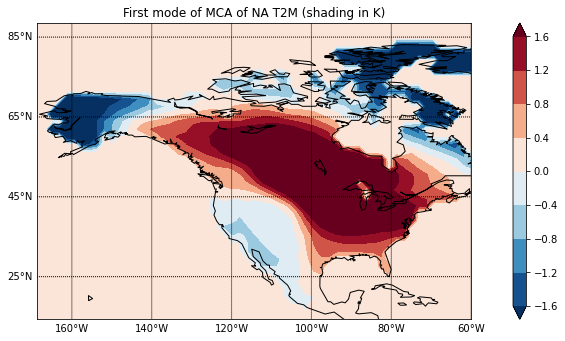

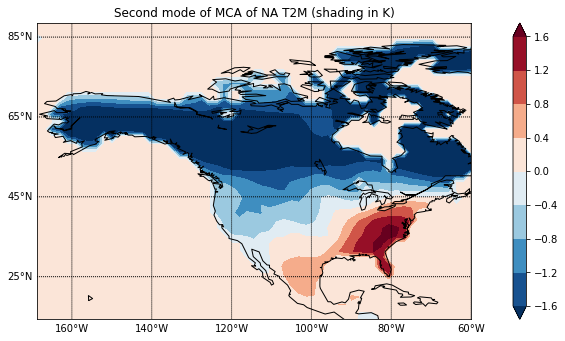

In [447]:
map_temp(U1_djf_norm, 'First mode of MCA of NA T2M (shading in K)')
map_temp(U2_djf_norm, 'Second mode of MCA of NA T2M (shading in K)')

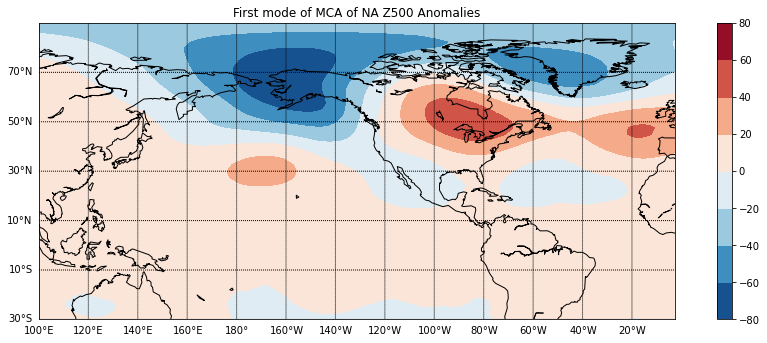

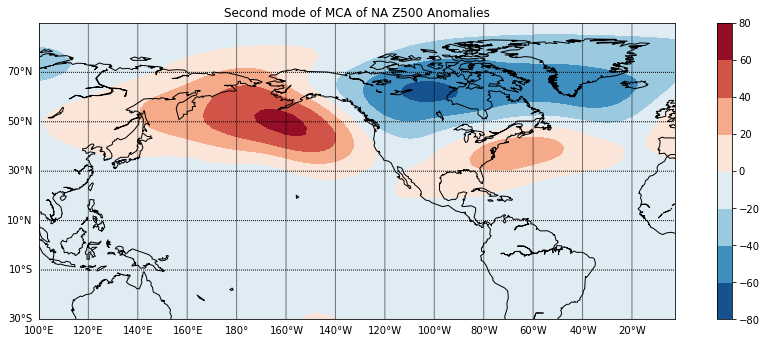

In [448]:
map_hgt(V1_djf_norm, 'First mode of MCA of NA Z500 Anomalies')
map_hgt(V2_djf_norm, 'Second mode of MCA of NA Z500 Anomalies')


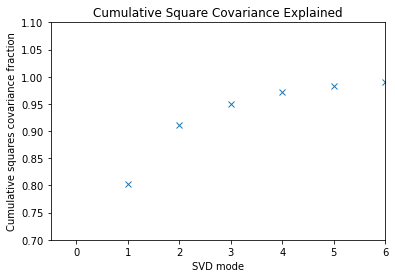

In [449]:
scf = djf_results[8]

plt.plot(np.cumsum(scf),'x') 
plt.xlabel('SVD mode')
plt.ylabel('Cumulative squares covariance fraction')
plt.ylim([0.7,1.1])
plt.xlim([-0.5, 6])
plt.title('Cumulative Square Covariance Explained')
plt.savefig('Covar_Explained.png')

In [450]:
mam_results = svd(temp_anom_mam, hgt_mam_anom)
U1_mam_norm = mam_results[0]
a1_mam_norm = mam_results[1]
U2_mam_norm = mam_results[2]
a2_mam_norm = mam_results[3]

V1_mam_norm = mam_results[4]
b1_mam_norm = mam_results[5]
V2_mam_norm = mam_results[6]
b2_mam_norm = mam_results[7]

0.5746023
0.19504783


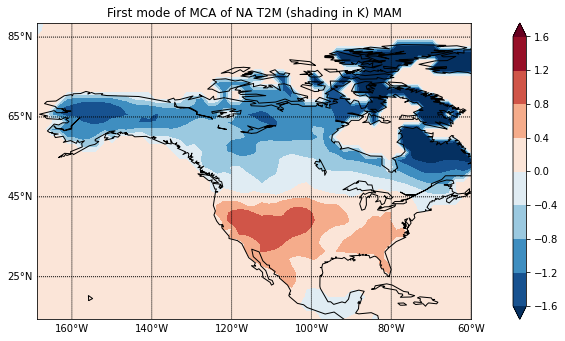

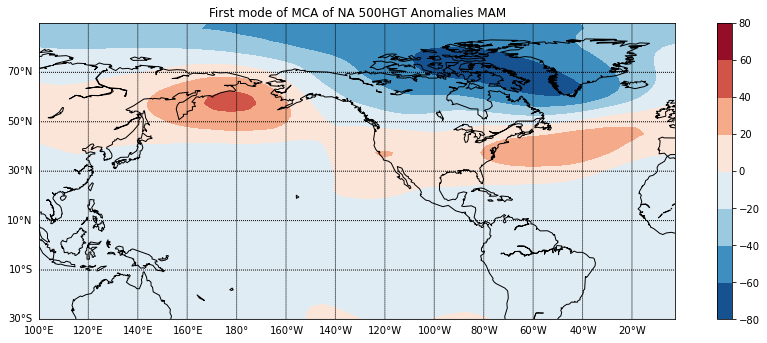

In [451]:
map_temp(U1_mam_norm, 'First mode of MCA of NA T2M (shading in K) MAM')
map_hgt(V1_mam_norm, 'First mode of MCA of NA 500HGT Anomalies MAM')

In [452]:
jja_results = svd(temp_anom_jja, hgt_jja_anom)
U1_jja_norm = jja_results[0]
a1_jja_norm = jja_results[1]
U2_jja_norm = jja_results[2]
a2_jja_norm = jja_results[3]

V1_jja_norm = jja_results[4]
b1_jja_norm = jja_results[5]
V2_jja_norm = jja_results[6]
b2_jja_norm = jja_results[7]

0.4903412
0.20656528


In [453]:
son_results = svd(temp_anom_son, hgt_son_anom)
U1_son_norm = son_results[0]
a1_son_norm = son_results[1]
U2_son_norm = son_results[2]
a2_son_norm = son_results[3]

V1_son_norm = son_results[4]
b1_son_norm = son_results[5]
V2_son_norm = son_results[6]
b2_son_norm = son_results[7]

0.45365608
0.25631803


In [454]:
ond_results = svd(temp_anom_ond, hgt_ond_anom)
U1_ond_norm = ond_results[0]
a1_ond_norm = ond_results[1]
U2_ond_norm = ond_results[2]
a2_ond_norm = ond_results[3]

V1_ond_norm = ond_results[4]
b1_ond_norm = ond_results[5]
V2_ond_norm = ond_results[6]
b2_ond_norm = ond_results[7]

0.49965534
0.2850334


Calculate Expansion Coefficients

In [498]:
EC1_djf = calculate_EC(a1_djf_norm, b1_djf_norm, a2_djf_norm, b2_djf_norm)[0]
EC2_djf = calculate_EC(a1_djf_norm, b1_djf_norm, a2_djf_norm, b2_djf_norm)[1]


In [499]:
# print(nao_annual.shape)
# print(EC1_djf.shape)
EC1_djf = np.squeeze(EC1_djf)
find_correlation(EC1_djf, nao_annual)

Correlation: 0.36203958744392944
P-value: 0.02001752796558697


(0.36203958744392944, 0.02001752796558697)

In [500]:
EC2_djf = np.squeeze(EC2_djf)
find_correlation(EC2_djf, nao_annual)

Correlation: 0.3841662343272549
P-value: 0.01314663898721352


(0.3841662343272549, 0.01314663898721352)

In [502]:
EC1_djf = calculate_EC(a1_djf_norm, b1_djf_norm, a2_djf_norm, b2_djf_norm)[2]
EC2_djf = calculate_EC(a1_djf_norm, b1_djf_norm, a2_djf_norm, b2_djf_norm)[3]


In [503]:
EC2_djf = np.squeeze(EC2_djf)
find_correlation(EC2_djf, pna_djf)

Correlation: -0.6423928282413898
P-value: 1.1598360936148266e-15


(-0.6423928282413898, 1.1598360936148266e-15)

In [504]:
EC1_djf = np.squeeze(EC1_djf)
find_correlation(EC1_djf, pna_djf)

Correlation: 0.17967501654185597
P-value: 0.046749776307608945


(0.17967501654185597, 0.046749776307608945)

In [299]:
EC1_mam = calculate_EC(a1_mam_norm, b1_mam_norm, a2_mam_norm, b2_mam_norm)[0]
EC2_mam = calculate_EC(a1_mam_norm, b1_mam_norm, a2_mam_norm, b2_mam_norm)[1]

In [300]:
EC1_jja = calculate_EC(a1_jja_norm, b1_jja_norm, a2_jja_norm, b2_jja_norm,)[0]
EC2_jja = calculate_EC(a1_jja_norm, b1_jja_norm, a2_jja_norm, b2_jja_norm,)[1]

In [301]:
EC1_son = calculate_EC(a1_son_norm, b1_son_norm, a2_son_norm, b2_son_norm)[0]
EC2_son = calculate_EC(a1_son_norm, b1_son_norm, a2_son_norm, b2_son_norm)[1]

In [302]:
EC1_ond = calculate_EC(a1_ond_norm, b1_ond_norm, a2_ond_norm, b2_ond_norm)[0]
EC2_ond = calculate_EC(a1_ond_norm, b1_ond_norm, a2_ond_norm, b2_ond_norm)[1]

Import PNA Data

In [303]:
pna_mam = read_file('C:/Users/inigo/Documents/MATLAB/NCEP_Data/NCEP_R2/pna_index.txt', 'mam')
#PNA index found at https://www.cpc.ncep.noaa.gov/data/teledoc/pna.shtml

     Year  Month    Value
362  1980      3 -0.35000
363  1980      4  1.96000
364  1980      5 -0.28000
374  1981      3  1.60000
375  1981      4 -1.02000
..    ...    ...      ...
831  2019      4 -0.61161
832  2019      5 -0.29073
842  2020      3 -2.17100
843  2020      4 -1.17560
844  2020      5  0.21074

[123 rows x 3 columns]


In [304]:
pna_djf = read_file('C:/Users/inigo/Documents/MATLAB/NCEP_Data/NCEP_R2/pna_index.txt', 'djf')

     Year  Month    Value
359  1979     12 -0.38000
360  1980      1 -0.28000
361  1980      2  1.74000
371  1980     12 -0.27000
372  1981      1  2.42000
..    ...    ...      ...
828  2019      1  0.83423
829  2019      2 -1.07600
839  2019     12  0.18092
840  2020      1 -0.23693
841  2020      2  0.17219

[123 rows x 3 columns]


In [305]:
pna_jja = read_file('C:/Users/inigo/Documents/MATLAB/NCEP_Data/NCEP_R2/pna_index.txt', 'jja')

     Year  Month    Value
365  1980      6 -0.86000
366  1980      7 -0.42000
367  1980      8 -1.99000
377  1981      6 -0.20000
378  1981      7 -0.64000
..    ...    ...      ...
834  2019      7  1.11160
835  2019      8  1.17860
845  2020      6  0.70378
846  2020      7  1.72760
847  2020      8  1.82180

[123 rows x 3 columns]


In [306]:
pna_son = read_file('C:/Users/inigo/Documents/MATLAB/NCEP_Data/NCEP_R2/pna_index.txt', 'son')

     Year  Month     Value
368  1980      9 -0.050000
369  1980     10  2.450000
370  1980     11  1.350000
380  1981      9  0.150000
381  1981     10 -1.450000
..    ...    ...       ...
837  2019     10 -1.024100
838  2019     11 -0.056486
848  2020      9  0.753560
849  2020     10 -1.131200
850  2020     11  0.235140

[123 rows x 3 columns]


In [307]:
pna_ond = read_file('C:/Users/inigo/Documents/MATLAB/NCEP_Data/NCEP_R2/pna_index.txt', 'ond')

     Year  Month     Value
369  1980     10  2.450000
370  1980     11  1.350000
371  1980     12 -0.270000
381  1981     10 -1.450000
382  1981     11  1.260000
..    ...    ...       ...
838  2019     11 -0.056486
839  2019     12  0.180920
849  2020     10 -1.131200
850  2020     11  0.235140
851  2020     12  1.584400

[123 rows x 3 columns]


Find PNA Contribution in Geopotential Height

In [308]:
djf_pna_hgt = new_hgt_data(months = [12,1,2])
djf_anom_hgt = detrend_hgt(djf_pna_hgt)

mam_pna_hgt = new_hgt_data(months = [3,4,5])
mam_anom_hgt = detrend_hgt(djf_pna_hgt)

jja_pna_hgt = new_hgt_data(months = [6,7,8])
jja_anom_hgt = detrend_hgt(jja_pna_hgt)

son_pna_hgt = new_hgt_data(months = [9,10,11])
son_anom_hgt = detrend_hgt(son_pna_hgt)

In [309]:
ond_pna_hgt = new_hgt_data(months = [10,11,12])
ond_anom_hgt = detrend_hgt(ond_pna_hgt)

In [310]:
EC1 = calculate_EC(a1_djf_norm, b1_djf_norm, a2_djf_norm, b2_djf_norm)[2]
# EC1 = np.squeeze(EC1)
EC2 = calculate_EC(a1_djf_norm, b1_djf_norm, a2_djf_norm, b2_djf_norm)[3]
# EC2 = np.squeeze(EC2)
ec1_coef = hgt_regressed_ec(djf_anom_hgt,EC1)
ec2_coef = hgt_regressed_ec(djf_anom_hgt,EC2)

In [311]:
PNA_djf_contribution = pna_contribution(djf_anom_hgt, pna_djf)

In [312]:
PNA_mam_contribution = pna_contribution(mam_anom_hgt, pna_mam)

In [313]:
PNA_jja_contribution = pna_contribution(jja_anom_hgt, pna_jja)

In [314]:
PNA_son_contribution = pna_contribution(son_anom_hgt, pna_son)

In [315]:
PNA_ond_contribution = pna_contribution(ond_anom_hgt, pna_ond)

Calculate ABNA and New Index

In [316]:
ABNA_DJF = calculate_index(djf_anom_hgt, PNA_djf_contribution)[0]
New_index_DJF = calculate_index(djf_anom_hgt, PNA_djf_contribution)[1]
noPNA = calculate_index(djf_anom_hgt, PNA_djf_contribution)[2]
ABNA_DJF_seasonal = np.mean(ABNA_DJF.Value.values.reshape(-1, 3), axis = 1)
New_index_DJF_seasonal = np.mean(New_index_DJF.Value.values.reshape(-1, 3), axis = 1)

In [367]:
print(ABNA_DJF)

        Value
0    2.158991
1   -0.109134
2   -1.575371
3    0.347107
4   -0.464934
..        ...
118  0.616054
119 -3.147948
120  0.756943
121  1.446138
122  1.530390

[123 rows x 1 columns]


In [359]:
Third_index_DJF = calculate_index(djf_anom_hgt, PNA_djf_contribution)[3]
Third_index_DJF_seasonal = np.mean(Third_index_DJF.Value.values.reshape(-1, 3), axis = 1)

In [317]:
# djf_anom_hgt = np.mean(djf_anom_hgt.reshape(-1, 3, 49, 130), axis = 1)
# # print(djf_anom_hgt.shape)

In [318]:
# noPNA_seasonal = np.mean(noPNA.reshape(-1, 3, 49, 130), axis=1)

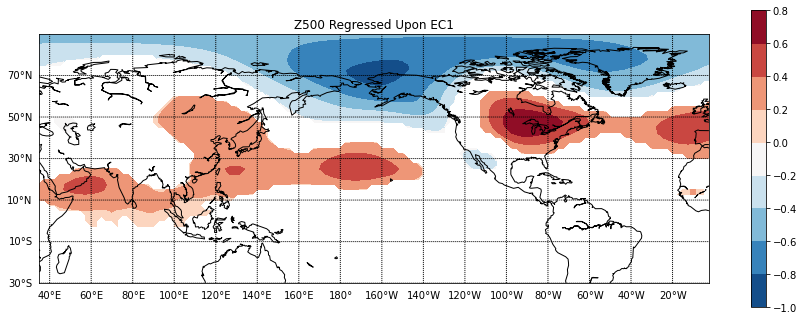

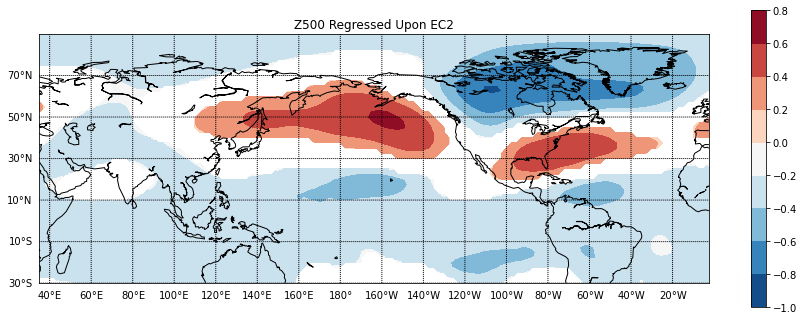

In [319]:
# print(EC1.shape)
# print(djf_anom_hgt.shape)
map_hgt_ec(djf_anom_hgt, EC1, 'Z500 Regressed Upon EC1')
map_hgt_ec(djf_anom_hgt, EC2, 'Z500 Regressed Upon EC2')
# map_hgt_ec(djf_anom_hgt, noPNA, 'EC1-PNA')

In [397]:
abna_djf = create_data_frame(ABNA_DJF, ["Dec", "Jan", "Feb"])
new_index_djf = create_data_frame(New_index_DJF, ["Dec", "Jan", "Feb"])

In [398]:
years = list(range(1980, 2021))
d = {'Years': years}
years = pd.DataFrame(d)

In [399]:
ABNA_MAM = calculate_index(mam_anom_hgt, PNA_mam_contribution)[0]
New_index_MAM = calculate_index(mam_anom_hgt, PNA_mam_contribution)[1]
ABNA_MAM_seasonal = np.mean(ABNA_MAM.Value.values.reshape(-1, 3), axis = 1)
New_index_MAM_seasonal = np.mean(New_index_MAM.Value.values.reshape(-1, 3), axis = 1)

In [400]:
abna_mam = create_data_frame(ABNA_MAM, ["Mar", "Apr", "May"])
new_index_mam = create_data_frame(New_index_MAM, ["Mar", "Apr", "May"])

In [401]:
ABNA_JJA = calculate_index(jja_anom_hgt, PNA_jja_contribution)[0]
New_index_JJA = calculate_index(jja_anom_hgt, PNA_jja_contribution)[1]
ABNA_JJA_seasonal = np.mean(ABNA_JJA.Value.values.reshape(-1, 3), axis = 1)
New_index_JJA_seasonal = np.mean(New_index_JJA.Value.values.reshape(-1, 3), axis = 1)

In [402]:
abna_jja = create_data_frame(ABNA_JJA, ["Jun", "Jul", "Aug"])
new_index_jja = create_data_frame(New_index_JJA, ["Jun", "Jul", "Aug"])

In [403]:
ABNA_SON = calculate_index(son_anom_hgt, PNA_son_contribution)[0]
New_index_SON = calculate_index(son_anom_hgt, PNA_son_contribution)[1]
ABNA_SON_seasonal = np.mean(ABNA_SON.Value.values.reshape(-1, 3), axis = 1)
New_index_SON_seasonal = np.mean(New_index_SON.Value.values.reshape(-1, 3), axis = 1)

In [404]:
abna_son = create_data_frame(ABNA_SON, ["Sept", "Oct", "Nov"])
new_index_son = create_data_frame(New_index_SON, ["Sept", "Oct", "Nov"])

In [405]:
abna_monthly = pd.concat([years, abna_djf, abna_mam, abna_jja, abna_son], axis = 1)
abna_monthly.to_csv('Monthly_ABNA_Values.csv',index=False)

In [385]:
print(abna_monthly.Jan)

0    -0.109134
1    -0.464934
2    -0.918611
3     1.558619
4     1.025103
5    -2.861405
6     0.835841
7     0.489780
8    -0.861103
9     2.204452
10   -0.093250
11    0.044626
12    1.205954
13    1.169678
14   -2.107829
15    0.352448
16   -0.301404
17    0.872756
18    0.427643
19    0.898398
20    2.778061
21    0.036831
22   -0.100961
23   -0.601872
24   -1.371474
25   -0.057295
26    2.012126
27    1.335927
28    0.214358
29    0.931048
30    0.810676
31   -0.407239
32    2.556549
33   -1.395302
34   -0.861407
35    0.862842
36   -0.226375
37    1.250189
38    0.345638
39    0.616054
40    1.446138
Name: Jan, dtype: float64


In [386]:
new_index_monthly = pd.concat([years, new_index_djf, new_index_mam, new_index_jja, new_index_son], axis = 1)
new_index_monthly.to_csv('Monthly_NewIndex_Values.csv',index=False)

In [387]:
New_Index_Values = pd.concat([New_index_DJF,New_index_MAM, New_index_JJA, New_index_SON], axis = 1)
New_Index_Values.columns = [' DJF', 'MAM', 'JJA','SON']
New_Index_Values.to_csv('Monthly_New_index_Values.csv',index=False)

In [364]:
ABNA_OND = calculate_index(ond_anom_hgt, PNA_ond_contribution)[0]
New_index_OND = calculate_index(ond_anom_hgt, PNA_ond_contribution)[1]
Third_index_OND = calculate_index(ond_anom_hgt, PNA_ond_contribution)[3]
ABNA_OND_seasonal = np.mean(ABNA_OND.Value.values.reshape(-1, 3), axis = 1)
New_index_OND_seasonal = np.mean(New_index_OND.Value.values.reshape(-1, 3), axis = 1)
Third_index_OND_seasonal = np.mean(Third_index_OND.Value.values.reshape(-1, 3), axis = 1)

In [332]:
print(ABNA_MAM.shape)

(123, 1)


Find Correlations Between Indices and Ice Coverage

In [333]:
ao_djf = read_file('C:/Users/inigo/Documents/MATLAB/NCEP_Data/NCEP_R2/ao_index.txt', 'djf')

     Year  Month    Value
359  1979     12  1.29480
360  1980      1 -2.06570
361  1980      2 -0.93372
371  1980     12 -0.05730
372  1981      1 -0.11634
..    ...    ...      ...
828  2019      1 -0.71320
829  2019      2  1.14950
839  2019     12  0.41207
840  2020      1  2.41900
841  2020      2  3.41720

[123 rows x 3 columns]


In [334]:
ao_mam = read_file('C:/Users/inigo/Documents/MATLAB/NCEP_Data/NCEP_R2/ao_index.txt', 'mam')

     Year  Month     Value
362  1980      3 -1.433300
363  1980      4 -0.419130
364  1980      5 -1.154800
374  1981      3 -1.644700
375  1981      4  0.430410
..    ...    ...       ...
831  2019      4 -0.255310
832  2019      5 -1.231300
842  2020      3  2.641400
843  2020      4  0.928110
844  2020      5 -0.027055

[123 rows x 3 columns]


In [335]:
ao_jja = read_file('C:/Users/inigo/Documents/MATLAB/NCEP_Data/NCEP_R2/ao_index.txt', 'jja')

     Year  Month    Value
365  1980      6  0.72149
366  1980      7 -0.62221
367  1980      8 -0.18519
377  1981      6 -0.43793
378  1981      7  0.56055
..    ...    ...      ...
834  2019      7 -0.88969
835  2019      8 -0.72177
845  2020      6 -0.12180
846  2020      7 -0.41182
847  2020      8 -0.38117

[123 rows x 3 columns]


In [336]:
ao_son = read_file('C:/Users/inigo/Documents/MATLAB/NCEP_Data/NCEP_R2/ao_index.txt', 'son')

     Year  Month     Value
368  1980      9  0.312620
369  1980     10 -0.521210
370  1980     11 -1.361000
380  1981      9 -1.040100
381  1981     10 -1.167500
..    ...    ...       ...
836  2019      9  0.306200
837  2019     10 -0.082195
838  2019     11 -1.193400
848  2020      9  0.631420
849  2020     10 -0.071711

[122 rows x 3 columns]


In [337]:
ao_annual = np.mean(ao_djf.values.reshape(-1,3), axis = 1)
print(ao_annual.shape)
# print(ao_djf.values)

(41,)


In [338]:
find_correlation(ao_annual, ABNA_DJF_seasonal)

Correlation: 0.3898486325071554
P-value: 0.011747919389117541


(0.3898486325071554, 0.011747919389117541)

In [339]:
find_correlation(ao_annual, New_index_DJF_seasonal)

Correlation: 0.17971716417350497
P-value: 0.2608653637763044


(0.17971716417350497, 0.2608653637763044)

In [340]:
nao_djf = read_file('C:/Users/inigo/Documents/MATLAB/NCEP_Data/NCEP_R2/nao_index.txt', 'djf')

     Year  Month    Value
359  1979     12  1.00000
360  1980      1 -0.75000
361  1980      2  0.05000
371  1980     12  0.78000
372  1981      1  0.37000
..    ...    ...      ...
828  2019      1  0.59202
829  2019      2  0.29141
839  2019     12  1.20160
840  2020      1  1.34320
841  2020      2  1.25700

[123 rows x 3 columns]


In [341]:
nao_annual = np.mean(nao_djf.values.reshape(-1,3), axis = 1)

In [342]:
find_correlation(nao_annual,  ABNA_DJF_seasonal)

Correlation: 0.28527118560077286
P-value: 0.07062018251264814


(0.28527118560077286, 0.07062018251264814)

In [343]:
find_correlation(nao_annual,  New_index_DJF_seasonal)

Correlation: 0.21926054310731502
P-value: 0.16840034943220122


(0.21926054310731502, 0.16840034943220122)

In [344]:
amic_data = pd.read_csv('C:/Users/inigo/Documents/MATLAB/NCEP_Data/NCEP_R2/dates_AMIC.txt',delim_whitespace = True, header = None, skiprows = 2)
amic_data = amic_data.drop(amic_data.columns[[2,4,6,8,10,12,13]],axis = 1)
amic_data.columns = ['Year', 'Superior', 'Michigan','Huron','Erie', 'Ontario', 'All_Lakes']
amic_data.drop(amic_data[(amic_data.Year < 1980)].index, inplace= True)
amic_data.drop(amic_data[(amic_data.Year > 2020)].index, inplace = True)
print(amic_data)
all_lakes = amic_data.All_Lakes
superior = amic_data.Superior
michigan = amic_data.Michigan
huron = amic_data.Huron
erie = amic_data.Erie
ontario = amic_data.Ontario
lakes = []
lakes.append(all_lakes)
lakes.append(superior)
lakes.append(michigan)
lakes.append(huron)
lakes.append(erie)
lakes.append(ontario)
print(all_lakes.shape)

    Year  Superior  Michigan  Huron   Erie  Ontario  All_Lakes
7   1980      77.2      38.6  70.30   93.4     30.6       62.8
8   1981      84.7      53.8  93.80   96.0     47.6       71.3
9   1982      85.3      60.2  93.30   99.1     50.7       74.8
10  1983      20.2      23.6  31.80   40.8     12.5       22.1
11  1984      88.2      43.3  77.60   95.7     40.7       65.2
12  1985      81.9      41.3  87.40   96.0     38.2       69.8
13  1986      90.7      66.8  73.50   95.5     43.7       76.4
14  1987      14.5      20.0  43.50   88.0      8.4       27.3
15  1988      67.3      32.7  60.10   91.5     21.1       53.6
16  1989      82.3      30.9  76.30   91.6     15.5       59.2
17  1990      78.1      32.4  73.80   72.8     29.5       59.7
18  1991      89.6      21.5  43.80   35.1     11.6       44.3
19  1992      73.3      32.8  69.90   89.8     17.5       45.5
20  1993      77.2      32.2  78.30   94.3     29.0       64.4
21  1994      96.1      82.7  96.90   96.7     55.7    

In [345]:
for lake in lakes:
    print("\n" + lake.name + ' AMIC and AO Index')
    find_correlation(ao_annual, lake)


All_Lakes AMIC and AO Index
Correlation: -0.04212810385444321
P-value: 0.7936873828062606

Superior AMIC and AO Index
Correlation: 0.023158046320940345
P-value: 0.8857237345323156

Michigan AMIC and AO Index
Correlation: -0.14270004653431312
P-value: 0.3734466079945587

Huron AMIC and AO Index
Correlation: -0.013465669833030741
P-value: 0.9334065875762945

Erie AMIC and AO Index
Correlation: -0.19312618982400345
P-value: 0.22635658893481722

Ontario AMIC and AO Index
Correlation: -0.12692994960173945
P-value: 0.42904897512839024


In [346]:
print(ABNA_DJF_seasonal.shape)
print(lake.shape)

(41,)
(41,)


In [396]:
for lake in lakes:
    print("\n" + lake.name + ' AMIC and ABNA Index')
    find_correlation(new_index_monthly.Oct, lake)


All_Lakes AMIC and ABNA Index
Correlation: -0.014491459621965047
P-value: 0.9283462869802309

Superior AMIC and ABNA Index
Correlation: -0.018816565933721066
P-value: 0.9070431088510202

Michigan AMIC and ABNA Index
Correlation: 0.012595721487022711
P-value: 0.9377001456010412

Huron AMIC and ABNA Index
Correlation: 0.008216999557423568
P-value: 0.9593349608566033

Erie AMIC and ABNA Index
Correlation: 0.18786220836991674
P-value: 0.2395098458686058

Ontario AMIC and ABNA Index
Correlation: 0.06224543407598492
P-value: 0.69904142957716


In [348]:
for lake in lakes:
    print("\n" + lake.name + ' and New Index')
    find_correlation(New_index_DJF_seasonal, lake)


All_Lakes and New Index
Correlation: -0.6157178257052075
P-value: 1.8285297352595e-05

Superior and New Index
Correlation: -0.583876279004103
P-value: 6.139487141450445e-05

Michigan and New Index
Correlation: -0.5115820186464732
P-value: 0.0006294669654819887

Huron and New Index
Correlation: -0.5989737378202222
P-value: 3.5132371978346246e-05

Erie and New Index
Correlation: -0.4756041943971311
P-value: 0.0016739875916309285

Ontario and New Index
Correlation: -0.4376613792436004
P-value: 0.004214618546644911


In [365]:
# print(lake)
for lake in lakes:
    print("\n" + lake.name + ' and Third Index')
    find_correlation(Third_index_OND_seasonal, lake)


All_Lakes and Third Index
Correlation: -0.11879778549484418
P-value: 0.45943438034659173

Superior and Third Index
Correlation: -0.16732694697628542
P-value: 0.29571060813881916

Michigan and Third Index
Correlation: -0.07150692344316686
P-value: 0.6568419688513877

Huron and Third Index
Correlation: -0.13545862421155416
P-value: 0.3984252010140929

Erie and Third Index
Correlation: -0.20242660920133443
P-value: 0.20434589190085387

Ontario and Third Index
Correlation: -0.22878955539270907
P-value: 0.15019939724312242


In [194]:
for lake in lakes:
    print("\n" + lake.name + ' and NAO Index')
    find_correlation(nao_annual, lake)


All_Lakes and NAO Index
Correlation: 0.02529111835970163
P-value: 0.8752771330874706

Superior and NAO Index
Correlation: 0.015144140462369726
P-value: 0.9251279981576884

Michigan and NAO Index
Correlation: 0.043516876197034204
P-value: 0.7870412080064537

Huron and NAO Index
Correlation: -0.023294870468035467
P-value: 0.885053053586557

Erie and NAO Index
Correlation: -0.1350366290749937
P-value: 0.39991000762255924

Ontario and NAO Index
Correlation: 0.08008169462232564
P-value: 0.6186842354623984


In [510]:
pna_annual = np.mean(pna_djf.values.reshape(-1,3), axis = 1)
for lake in lakes:
    print("\n" + lake.name + ' and PNA Index')
    find_correlation(pna_annual, lake)


All_Lakes and PNA Index
Correlation: -0.2559430716241977
P-value: 0.10627053484808517

Superior and PNA Index
Correlation: -0.2898585877337203
P-value: 0.06601967445608727

Michigan and PNA Index
Correlation: -0.1794408859961949
P-value: 0.2616112379277015

Huron and PNA Index
Correlation: -0.2741199255106124
P-value: 0.0828582140324489

Erie and PNA Index
Correlation: -0.12367076909186538
P-value: 0.4410896535746463

Ontario and PNA Index
Correlation: -0.10593217515125707
P-value: 0.5097808743171145


In [195]:
ao_data = pd.read_csv('C:/Users/inigo/Documents/MATLAB/NCEP_Data/NCEP_R2/ao_index.txt',delim_whitespace = True, header = None, 
                   names = ['Year', 'Month', 'ao_Value'])
ao_data.drop(ao_data[(ao_data.Month > 2) & (ao_data.Month < 12)].index, inplace= True)
ao_data.drop(ao_data[(ao_data.Year < 1972)].index, inplace= True)
ao_data.drop(ao_data[(ao_data.Year < 1973) & (ao_data.Month < 12)].index, inplace = True)
ao_data.drop(ao_data[(ao_data.Year > 1997)].index, inplace = True)

ao_data.drop(ao_data[(ao_data.Year > 1996) & (ao_data.Month > 2)].index, inplace = True)
print(ao_data)
ao_annual = np.mean(ao_data.ao_Value.values.reshape(-1,3), axis = 1)
print(ao_annual.shape)

     Year  Month  ao_Value
275  1972     12   1.23750
276  1973      1   1.23180
277  1973      2   0.78621
287  1973     12  -0.18148
288  1974      1   0.23216
..    ...    ...       ...
552  1996      1  -1.20040
553  1996      2   0.16321
563  1996     12  -1.72080
564  1997      1  -0.45677
565  1997      2   1.88870

[75 rows x 3 columns]
(25,)


In [196]:
amic_data = pd.read_csv('C:/Users/inigo/Documents/MATLAB/NCEP_Data/NCEP_R2/dates_AMIC.txt',delim_whitespace = True, header = None, skiprows = 2)
amic_data = amic_data.drop(amic_data.columns[[2,4,6,8,10,12,13]],axis = 1)
amic_data.columns = ['Year', 'Superior', 'Michigan','Huron','Erie', 'Ontario', 'All_Lakes']
amic_data.drop(amic_data[(amic_data.Year < 1973)].index, inplace= True)
amic_data.drop(amic_data[(amic_data.Year > 1997)].index, inplace = True)
print(amic_data)
all_lakes = amic_data.All_Lakes
superior = amic_data.Superior
michigan = amic_data.Michigan
huron = amic_data.Huron
erie = amic_data.Erie
ontario = amic_data.Ontario
lakes = []
lakes.append(all_lakes)
lakes.append(superior)
lakes.append(michigan)
lakes.append(huron)
lakes.append(erie)
lakes.append(ontario)
print(all_lakes.shape)

    Year  Superior  Michigan  Huron   Erie  Ontario  All_Lakes
0   1973      69.8      33.0   66.7   95.7     62.6       60.6
1   1974      73.8      39.4   61.4   88.5     24.5       58.7
2   1975      64.9      28.1   55.1   80.1     14.9       50.2
3   1976      49.9      29.5   52.5   95.4     15.2       39.9
4   1977      96.0      93.1   95.0   99.8     46.7       89.9
5   1978      92.5      66.6   95.8  100.0     57.7       83.0
6   1979      97.1      92.3   96.4  100.0     86.2       94.7
7   1980      77.2      38.6   70.3   93.4     30.6       62.8
8   1981      84.7      53.8   93.8   96.0     47.6       71.3
9   1982      85.3      60.2   93.3   99.1     50.7       74.8
10  1983      20.2      23.6   31.8   40.8     12.5       22.1
11  1984      88.2      43.3   77.6   95.7     40.7       65.2
12  1985      81.9      41.3   87.4   96.0     38.2       69.8
13  1986      90.7      66.8   73.5   95.5     43.7       76.4
14  1987      14.5      20.0   43.5   88.0      8.4    

In [197]:
find_correlation(all_lakes, ao_annual)

Correlation: -0.4942237961123757
P-value: 0.01203278160983592


(-0.4942237961123757, 0.01203278160983592)

In [198]:
binyu_data = pd.read_csv('C:/Users/inigo/Documents/MATLAB/NCEP_Data/NCEP_R2/abna.txt',delim_whitespace = True, header = None, skiprows = 1)
binyu_data.columns = ['Year', 'DJF', 'MAM','JJA','SON']
bin_djf = binyu_data.DJF
year = binyu_data.Year
bin_son = binyu_data.SON
# print(bin_djf)
bin_mam = binyu_data.MAM
bin_jja = binyu_data.JJA
# print(bin_abna)
year = np.arange(1980, 2016)
print(year)

[1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993
 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007
 2008 2009 2010 2011 2012 2013 2014 2015]


In [199]:
for lake in lakes:
    print("\n" + lake.name + ' and BinYu Index')
    find_correlation(bin_djf, lake)


All_Lakes and BinYu Index


ValueError: x and y must have the same length.

In [ ]:
find_correlation(bin_son, ABNA_SON_seasonal)

In [ ]:
find_correlation(bin_son, New_index_SON_seasonal)